# Data Mining Project

## Imports and Datasets

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import math

In [280]:
account = pd.read_csv('../data/account.csv',delimiter=';')
card_dev = pd.read_csv('../data/card_dev.csv',delimiter=';')
client = pd.read_csv('../data/client.csv',delimiter=';')
disp = pd.read_csv('../data/disp.csv',delimiter=';')
district = pd.read_csv('../data/district.csv',delimiter=';')
loan_dev = pd.read_csv('../data/loan_dev.csv',delimiter=';')
trans_dev = pd.read_csv('../data/trans_dev.csv',delimiter=';', dtype={'bank': str})

## Business Understanding

The bank wants to improve their services. For instance, the bank managers have only vague idea, who is a good client (whom to offer some additional services) and who is a bad client (whom to watch carefully to minimize the bank loses). Fortunately, the bank stores data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued. The bank managers hope to improve their understanding of customers and seek specific actions to improve services. A mere application of a discovery tool will not be convincing for them.  

To test a data mining approach to help the bank managers, it was decided to address two problems, a descriptive and a predictive one. While the descriptive problem was left open, the predictive problem is the prediction of whether a loan will end successfuly.

## Data Understanding

### Build Dataset

In [281]:
def parse_date(date):
  year = int(str(date)[0:2])
  month = int(str(date)[2:4])
  day = int(str(date)[4:6])
  return { 'year': year, 'month': month, 'day': day }


def parse_gender(row, birth_date):
  female = birth_date['month'] >= 50

  if female:
    row['gender'] = 'female' 
    birth_date['month'] -= 50
  else:
    row['gender'] = 'male' 


def calculate_age_loan(row):
  date_loan = row['date_loan']
  birth_number = row['birth_number']

  birth_date = parse_date(birth_number)

  parse_gender(row, birth_date)
  
  if (date_loan is None):
    date_loan = parse_date(row['date_loan'])
    date_loan = date_loan['year'] - birth_date['year'] - ((date_loan['month'], date_loan['day']) < (birth_date['month'], birth_date['day']))
  
  row['age_loan'] = date_loan
    
  return row

The mean for the unemployment rate and the total number of offenses committed are calculated in the following two cells of code.

Any missing value is set to the value of the column whose value is present, e.g. if the value for the "unemploymant rate '95" is not present in a certain row, it is set to the "unemploymant rate '96" value.

The reasoning behind this strategy was that, when taken into account over the course of just one year, neither the unemployment rate nor the number of crimes would be significant. 

In [282]:
def nan_unemploymant_rate(year): return district["unemploymant rate '" + str(year) + " "].isna()

# convert '?' to NaN

district['unemploymant rate \'95 '] = pd.to_numeric(district['unemploymant rate \'95 '], errors='coerce')
district['unemploymant rate \'96 '] = pd.to_numeric(district['unemploymant rate \'96 '], errors='coerce')

# NaN values will be equaled to the value of the other column

district.loc[nan_unemploymant_rate(95), 'unemploymant rate \'95 '] = district['unemploymant rate \'96 ']
district.loc[nan_unemploymant_rate(96), 'unemploymant rate \'96 '] = district['unemploymant rate \'95 ']

# create column with mean from both years and drop previous and now useless columns

district['unemploymant_rate'] = district[['unemploymant rate \'95 ', 'unemploymant rate \'96 ']].mean(axis=1)
district = district.drop(['unemploymant rate \'95 ', 'unemploymant rate \'96 '], axis= 1).reset_index()

In [283]:
def nan_commited_crimes(year): return district["no. of commited crimes '" + str(year) + " "].isna()

# convert '?' to NaN

district['no. of commited crimes \'95 '] = pd.to_numeric(district['no. of commited crimes \'95 '], errors='coerce')
district['no. of commited crimes \'96 '] = pd.to_numeric(district['no. of commited crimes \'96 '], errors='coerce')

# NaN values will be equaled to the value of the other column

district.loc[nan_commited_crimes(95), 'no. of commited crimes \'95 '] = district['no. of commited crimes \'96 ']
district.loc[nan_commited_crimes(96), 'no. of commited crimes \'96 '] = district['no. of commited crimes \'95 ']

# create column with mean from both years and drop previous and now useless columns

district['commited_crimes'] = district[['no. of commited crimes \'95 ', 'no. of commited crimes \'96 ']].mean(axis=1)
district = district.drop(['no. of commited crimes \'95 ', 'no. of commited crimes \'96 '], axis= 1).reset_index() 

In [284]:
# join account, loan, disposition and client
df = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='right')
df = df.merge(disp, on='account_id', suffixes=('','_disp'), how='left')
df = df.merge(client, on='client_id',suffixes=('','_client'), how='left')

df.drop(columns='district_id', axis=1, inplace=True)

# create age_at_loan and gender column
df = df.apply(lambda row: calculate_age_loan(row), axis=1)

# join demograph
district.rename(columns={'code ':'code'}, inplace=True)
df = df.merge(district, left_on='district_id_client', right_on='code', how='left')

# join creditcard
df = df.merge(card_dev, on='disp_id', suffixes=('', '_card'), how='left')

# join transactions
df_transactions = account.merge(loan_dev, on='account_id', suffixes=('','_loan'), how='right').merge(trans_dev, on='account_id', suffixes=('', '_transaction'), how='left')
df

,account_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,disp_id,...,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,no. of enterpreneurs per 1000 inhabitants,unemploymant_rate,commited_crimes,card_id,type_card,issued
0,1787,weekly issuance,930322,5314,930705,96396,12,8033,-1,2166,...,2,10,81.8,9650,100,3.525,2894.5,NaN,NaN,NaN
1,1801,monthly issuance,930213,5316,930711,165960,36,4610,1,2181,...,3,10,73.5,8369,117,2.050,2736.0,NaN,NaN,NaN
2,9188,monthly issuance,930208,6863,930728,127080,60,2118,1,11006,...,1,5,53.5,8390,132,2.585,2101.0,NaN,NaN,NaN
3,1843,monthly issuance,930130,5325,930803,105804,36,2939,1,2235,...,1,9,74.8,10045,135,1.565,6449.5,NaN,NaN,NaN
4,11013,weekly issuance,930214,7240,930906,274740,60,4579,1,13231,...,1,5,50.5,8288,110,4.155,1511.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,9030,monthly issuance,950121,6818,961212,155616,48,3242,1,10814,...,4,4,62.6,8994,110,4.295,9440.0,NaN,NaN,NaN
399,3189,monthly issuance,951129,5625,961215,222180,60,3703,-1,3855,...,1,6,55.6,8843,113,3.210,853.0,NaN,NaN,NaN
400,8972,monthly issuance,960521,6805,961221,45024,48,938,1,10742,...,5,7,89.9,10177,81,7.190,9993.0,NaN,NaN,NaN
401,10963,monthly issuance,950520,7233,961225,115812,36,3217,1,13172,...,1,8,56.9,8427,107,1.330,1893.5,NaN,NaN,NaN


### Exploratory Analysis

In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 402
Data columns (total 35 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   account_id                                         403 non-null    int64  
 1   frequency                                          403 non-null    object 
 2   date                                               403 non-null    int64  
 3   loan_id                                            403 non-null    int64  
 4   date_loan                                          403 non-null    int64  
 5   amount                                             403 non-null    int64  
 6   duration                                           403 non-null    int64  
 7   payments                                           403 non-null    int64  
 8   status                                             403 non-null    int64  
 9   disp_id   

In [286]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24494 entries, 0 to 24493
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   account_id          24494 non-null  int64  
 1   district_id         24494 non-null  int64  
 2   frequency           24494 non-null  object 
 3   date                24494 non-null  int64  
 4   loan_id             24494 non-null  int64  
 5   date_loan           24494 non-null  int64  
 6   amount              24494 non-null  int64  
 7   duration            24494 non-null  int64  
 8   payments            24494 non-null  int64  
 9   status              24494 non-null  int64  
 10  trans_id            24494 non-null  int64  
 11  date_transaction    24494 non-null  int64  
 12  type                24494 non-null  object 
 13  operation           20163 non-null  object 
 14  amount_transaction  24494 non-null  float64
 15  balance             24494 non-null  float64
 16  k_sy

Text(0.5, 1.0, 'Status count for bank loans')

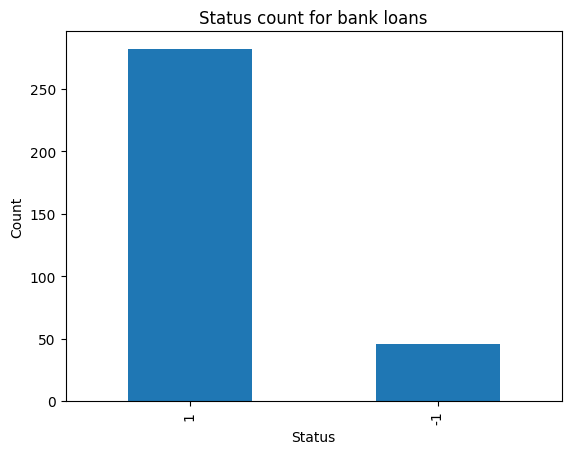

In [287]:
loan_dev['status'].value_counts().plot.bar()
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Status count for bank loans')

<AxesSubplot: title={'center': 'amount'}, xlabel='status'>

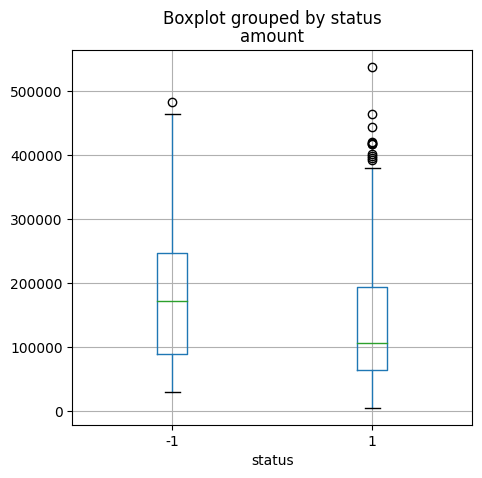

In [288]:
loan_dev.boxplot(column='amount', by='status', figsize=(5,5))

Since the boxes are not totally aligned, there might be a relation between the loan amount and the successfulness of a loan. The higher the amount, the most likely it is to fail. 

The differences in the graphics aren't, however, significant and our conclusions are enforced by logic.

<AxesSubplot: title={'center': 'payments'}, xlabel='status'>

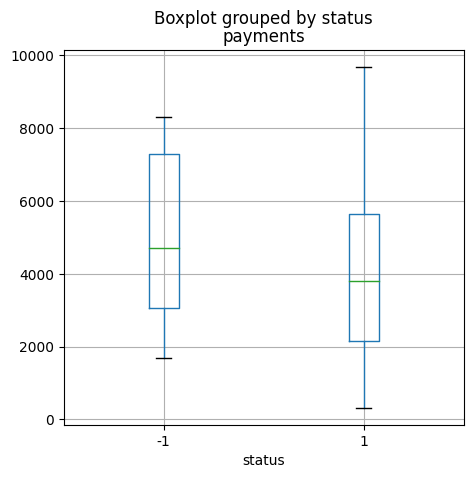

In [289]:
loan_dev.boxplot(column='payments', by='status', figsize=(5,5))

<AxesSubplot: title={'center': 'duration'}, xlabel='status'>

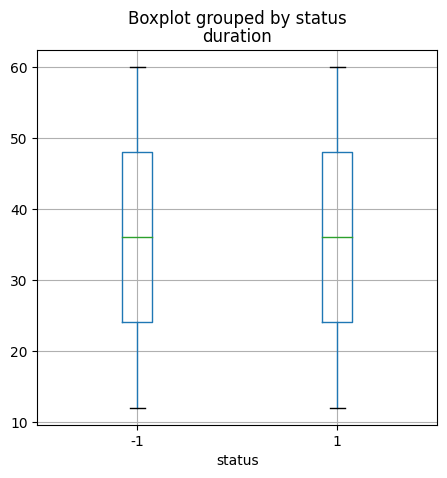

In [290]:
loan_dev.boxplot(column='duration', by='status', figsize=(5,5))

<AxesSubplot: title={'center': 'age_loan'}, xlabel='status'>

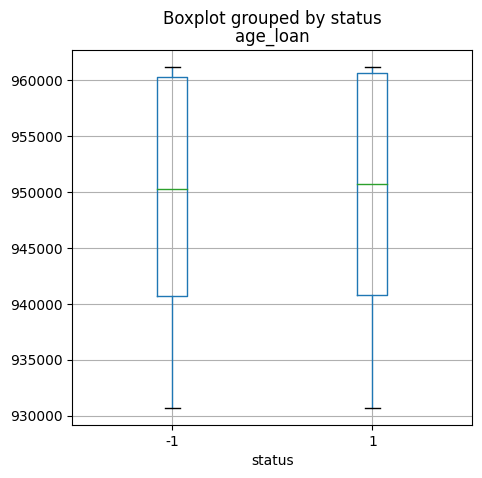

In [291]:
df.boxplot(column='age_loan', by='status', figsize=(5,5))

In [292]:
disp_count = df.groupby(['account_id'])['disp_id'].nunique() # number of disponents of each account

df = df.merge(disp_count, on='account_id', suffixes=('', '_count'), how='left')

<AxesSubplot: title={'center': 'disp_id_count'}, xlabel='status'>

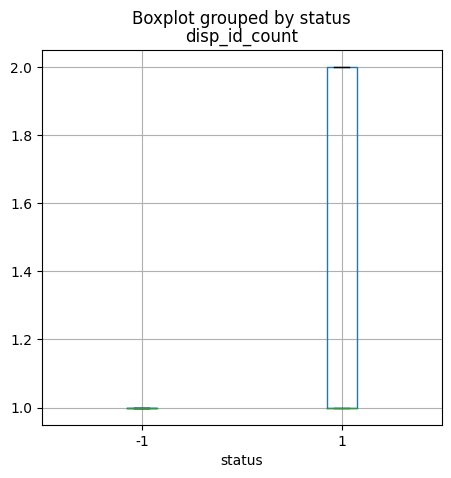

In [293]:
df.boxplot(column='disp_id_count', by='status', figsize=(5,5))

Text(0.5, 1.0, 'Status count by number of account disponents')

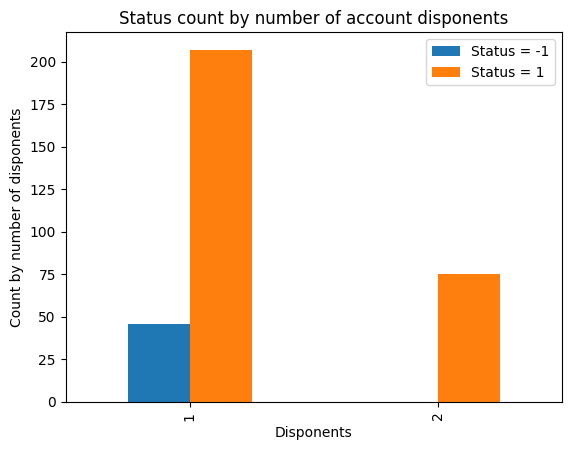

In [294]:
no_dups_df = df.drop_duplicates(subset=['account_id']) #remove duplicates
no_dups_df.groupby('disp_id_count')['status'].value_counts().unstack(1).plot.bar()

plt.xlabel('Disponents')
plt.ylabel('Count by number of disponents')
plt.legend(['Status = -1', 'Status = 1'])
plt.title('Status count by number of account disponents')

<AxesSubplot: title={'center': 'average salary '}, xlabel='status'>

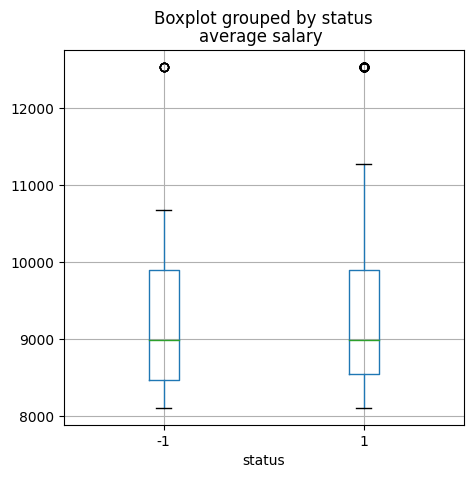

In [295]:
df.boxplot(column='average salary ', by='status', figsize=(5,5))

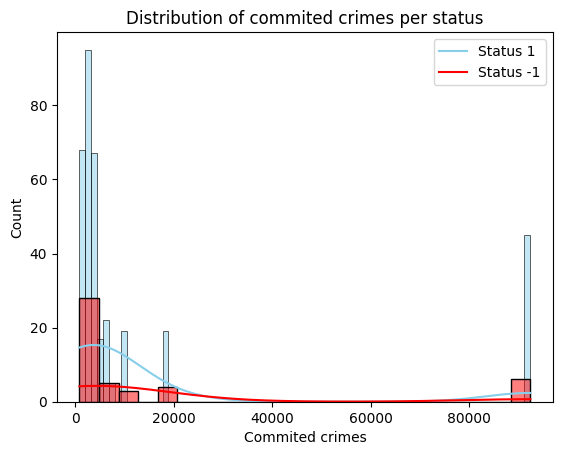

In [296]:
sns.histplot(data=df[df['status'] == 1], x='commited_crimes', color="skyblue", kde=True)
sns.histplot(data=df[df['status'] == -1], x='commited_crimes', color="red", kde=True)

plt.xlabel('Commited crimes')
plt.legend(['Status 1', 'Status -1'])
plt.title('Distribution of commited crimes per status')
plt.show()

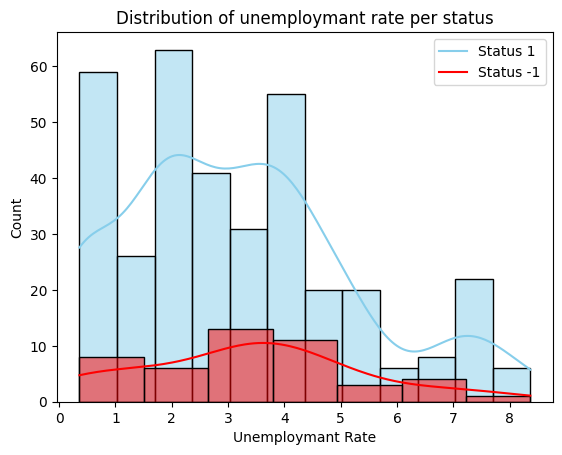

In [297]:
sns.histplot(data=df[df['status'] == 1], x='unemploymant_rate', color="skyblue", kde=True)
sns.histplot(data=df[df['status'] == -1], x='unemploymant_rate', color="red", kde=True)

plt.xlabel('Unemploymant Rate')
plt.legend(['Status 1', 'Status -1'])
plt.title('Distribution of unemploymant rate per status')
plt.show()

In [298]:
df['diff_salary_loan'] = df['average salary '] - df['payments']

<AxesSubplot: title={'center': 'diff_salary_loan'}, xlabel='status'>

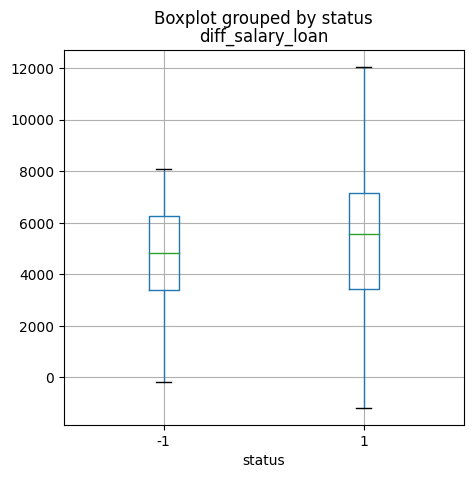

In [299]:
df.boxplot(column='diff_salary_loan', by='status', figsize=(5,5))

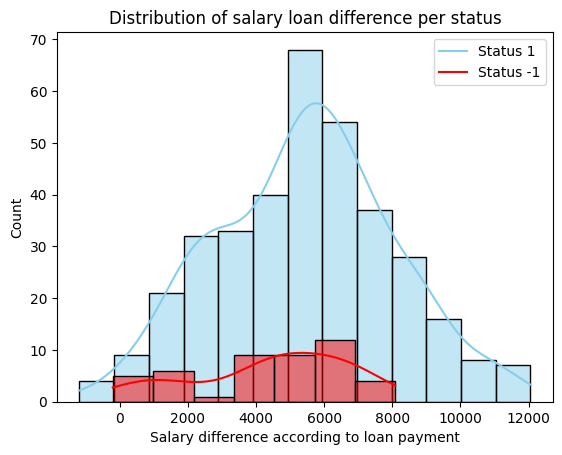

In [300]:
sns.histplot(data=df[df['status'] == 1], x='diff_salary_loan', color="skyblue", kde=True)
sns.histplot(data=df[df['status'] == -1], x='diff_salary_loan', color="red", kde=True)

plt.xlabel('Salary difference according to loan payment')
plt.legend(['Status 1', 'Status -1'])
plt.title('Distribution of salary loan difference per status')
plt.show()

Text(0.5, 1.0, 'Status count by gender')

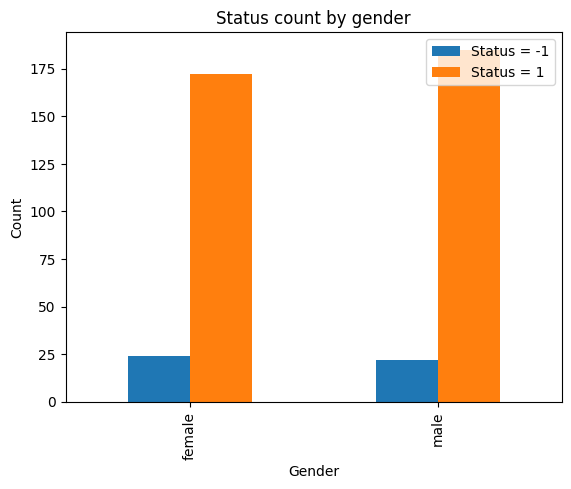

In [301]:
df.groupby('gender')['status'].value_counts().unstack(1).plot.bar()

plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(['Status = -1', 'Status = 1'])
plt.title('Status count by gender')

In [302]:
transaction_count = df_transactions.groupby(['account_id'])['trans_id'].nunique()

df_transactions = df_transactions.merge(transaction_count, on='account_id', suffixes=['_', '_count'], how='left')
df_transactions

,account_id,district_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,trans_id_,date_transaction,type,operation,amount_transaction,balance,k_symbol,bank,account,trans_id_count
0,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,523621,930322,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN,4
1,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,524054,930421,credit,credit in cash,9900.0,11000.0,NaN,NaN,NaN,4
2,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,524055,930521,credit,credit in cash,5800.0,16800.0,NaN,NaN,NaN,4
3,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,524056,930620,credit,credit in cash,3300.0,20100.0,NaN,NaN,NaN,4
4,1801,46,monthly issuance,930213,5316,930711,165960,36,4610,1,527445,930213,credit,credit in cash,700.0,700.0,NaN,NaN,NaN,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24489,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,3424164,961206,withdrawal,remittance to another bank,129.0,39765.5,,KL,20009470.0,107
24490,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,3424358,961207,withdrawal,withdrawal in cash,10400.0,29365.5,NaN,NaN,NaN,107
24491,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,3424116,961207,withdrawal,remittance to another bank,330.0,29035.5,insurrance payment,ST,40799850.0,107
24492,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,3424068,961208,withdrawal,remittance to another bank,56.0,28979.5,,MN,78507822.0,107


<AxesSubplot: title={'center': 'trans_id_count'}, xlabel='status'>

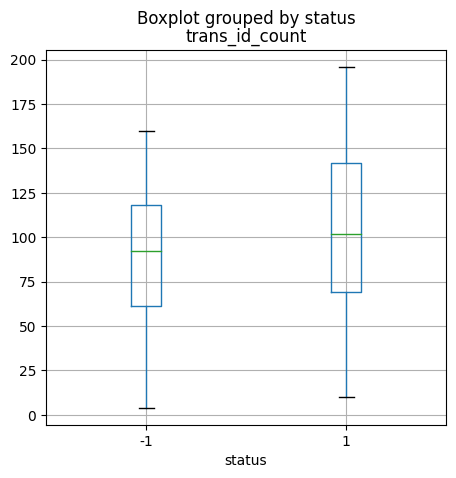

In [303]:
df_transactions.boxplot(column='trans_id_count', by='status', figsize=(5,5))

In [304]:
count_transactions_per_type = df_transactions.groupby(['account_id', 'type']).size().unstack(fill_value=0)
count_transactions_per_type['debit'] = count_transactions_per_type['withdrawal'] + count_transactions_per_type['withdrawal in cash']
count_transactions_per_type.drop(labels=['withdrawal', 'withdrawal in cash'], axis=1, inplace=True)
count_transactions_per_type['credit_debit_ratio'] = count_transactions_per_type['credit'] / count_transactions_per_type['debit']

df_transactions = df_transactions.merge(count_transactions_per_type, on='account_id', how='left')
df_transactions.replace([np.inf, -np.inf], 0, inplace=True)
df_transactions.rename({ 
    'trans_id_count': 'transactions_count', 
    'credit': 'credits_count', 
    'debit': 'debits_count' }, 
    axis=1, inplace=True)

df_transactions

,account_id,district_id,frequency,date,loan_id,date_loan,amount,duration,payments,status,...,operation,amount_transaction,balance,k_symbol,bank,account,transactions_count,credits_count,debits_count,credit_debit_ratio
0,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,...,credit in cash,1100.0,1100.0,NaN,NaN,NaN,4,4,0,0.000000
1,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,...,credit in cash,9900.0,11000.0,NaN,NaN,NaN,4,4,0,0.000000
2,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,...,credit in cash,5800.0,16800.0,NaN,NaN,NaN,4,4,0,0.000000
3,1787,30,weekly issuance,930322,5314,930705,96396,12,8033,-1,...,credit in cash,3300.0,20100.0,NaN,NaN,NaN,4,4,0,0.000000
4,1801,46,monthly issuance,930213,5316,930711,165960,36,4610,1,...,credit in cash,700.0,700.0,NaN,NaN,NaN,37,17,20,0.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24489,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,...,remittance to another bank,129.0,39765.5,,KL,20009470.0,107,29,78,0.371795
24490,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,...,withdrawal in cash,10400.0,29365.5,NaN,NaN,NaN,107,29,78,0.371795
24491,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,...,remittance to another bank,330.0,29035.5,insurrance payment,ST,40799850.0,107,29,78,0.371795
24492,11362,67,monthly issuance,951014,7308,961227,129408,24,5392,1,...,remittance to another bank,56.0,28979.5,,MN,78507822.0,107,29,78,0.371795


<AxesSubplot: title={'center': 'credit_debit_ratio'}, xlabel='status'>

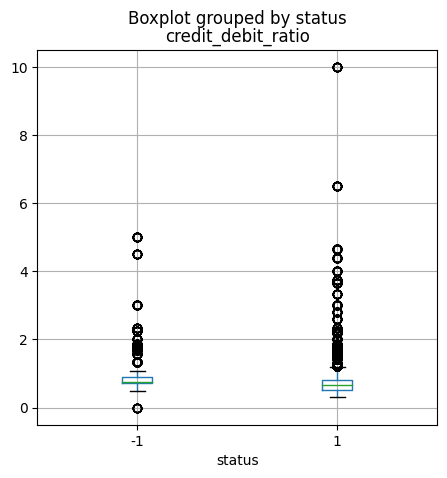

In [305]:
df_transactions.boxplot(column='credit_debit_ratio', by='status', figsize=(5,5))

## Data Preparation

## Model